# DSCI 633 Project
### Predicting Readmittance within 30 Days for Hospitalized Diabetes Patients  
*Michael Eaton, Rochester Institute of Technology — Fall 2025*


In [177]:
from ucimlrepo import fetch_ucirepo 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [178]:
# fetch dataset 
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296) 
  
# data (as pandas dataframes) 
X: pd.DataFrame = diabetes_130_us_hospitals_for_years_1999_2008.data.features  # type: ignore
y :pd.DataFrame = diabetes_130_us_hospitals_for_years_1999_2008.data.targets.copy()  # type: ignore


/home/mike/Git-projects/Eaton_633_Project/.venv/lib/python3.13/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


Fix columns not read as strings

In [ ]:
y['readmitted'] = y['readmitted'].astype('string')

y['target'] = (y['readmitted'] == '<30').astype(int)


# drop weight and payer_code missing and un informative
X_0 = X.drop(columns=['weight', 'payer_code'])


# fix diag column types
X_0['diag_1'] = X_0['diag_1'].astype('string')
X_0['diag_2'] = X_0['diag_2'].astype('string')
X_0['diag_3'] = X_0['diag_3'].astype('string')

# fix specialty column type
X_0['medical_specialty'] = X_0['medical_specialty'].astype('string')

# fix race
X_0['race'] = X_0['race'].astype('string')

# fix age
X_0['age'] = X_0['age'].astype('string')

X_0['change'] = X_0['change'].astype('string')


## Feature Exploration

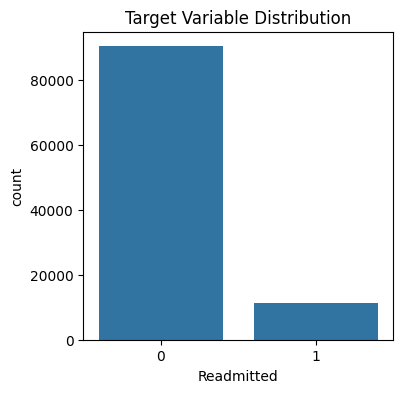

In [180]:
# target distribution shows obvious class imblance that will need to be addressed

plt.figure(figsize=(4,4))
sns.countplot(x='target', data=y)


plt.title('Target Variable Distribution')
plt.xlabel('Readmitted')
plt.ylabel('count')

plt.show()


## Feature Engineering
Bin, organize, impute missing data, drop some un-needed columns. 

The strategy that follows is based off of the strategy performed by Strack et al. in their study: 

*Impact of HbA1c Measurement on Hospital Readmission Rates:
Analysis of 70,000 Clinical Database Patient Records*

I'll start by copying the binning strategy used in Strack et al. to limit feature explosion

In [181]:
# bin diagnoses into groups 
_icd_num_re = re.compile(r'^(\d{3})(?:\.\d+)?$')   # e.g., '250.13' -> '250'

def _parse_icd9(code):
    """
    Returns (prefix, num) where:
      - prefix is 'E', 'V', or '' for numeric codes
      - num is an integer 3-digit number if numeric; else None
    """
    if code is None or (isinstance(code, float) and np.isnan(code)):
        return '', None
    s = str(code).strip()
    if not s:
        return '', None
    first = s[0].upper()
    if first in ('E', 'V'):
        return first, None
    m = _icd_num_re.match(s)
    if m:
        return '', int(m.group(1))
    # Try float -> int of floor integer part
    try:
        return '', int(float(s))
    except Exception:
        return '', None

def icd9_to_group(code):
    """
    Map a single ICD-9 code to the study's diagnosis group.
    """
    prefix, num = _parse_icd9(code)

    # External causes (E or V) 
    if prefix in ('E', 'V'):
        return 'other'

    if num is None:
        return 'other'

    # Special case: Diabetes 250.xx
    if 250 <= num <= 250:
        return 'diabetes'

    # Primary named groups
    if (390 <= num <= 459) or (num == 785):
        return 'circulatory'
    if (460 <= num <= 519) or (num == 786):
        return 'respiratory'
    if (520 <= num <= 579) or (num == 787):
        return 'digestive'
    if 800 <= num <= 999:
        return 'injury'
    if 710 <= num <= 739:
        return 'musculoskeletal'
    if (580 <= num <= 629) or (num == 788):
        return 'genitourinary'
    if 140 <= num <= 239:
        return 'neoplasms'

    return 'other'

In [182]:
# Admission source -> 3 bins
def bin_admit_source(id: int) -> str:
    if id == 7:
        return 'emergency'
    if id == 1 or id == 2:
        return 'refer'
    return 'other'


In [183]:
# Medical Specialty of admitting physician -> 6 bins including missing
def bin_medical_specialty(value: str) -> str:
    if pd.isna(value) or value in ("Missing", "Unknown", "PhysicianNotFound", "OutreachServices", "DCPTEAM"):
        return "missing"
    
    # normalize casing and spacing just in case
    val = str(value).strip().lower()
    
    # Internal Medicine
    if "internal" in val:
        return "internal_medicine"
    
    # Cardiology
    if "cardio" in val:
        return "cardiology"
    
    # Surgery (catch-all for surgical specialties)
    if "surg" in val or "orthopedic" in val or "urology" in val or "gyneco" in val or "neuro" in val or "vascular" in val or "thoracic" in val:
        return "surgery"
    
    # Family / General Practice
    if "family" in val or "general" in val or "gp" in val or "obstetric" in val or "pediatr" in val:
        return "pcp"
    
    # Everything else
    return "other"


In [184]:
# Discharge Dispostion -> 2 bins (home, other)
def bin_discharge(id: int) -> str:
    return 'home' if id == 1 else 'other'

In [185]:
# bin race -> Hispanic/Asian -> other since they have few values
def bin_race(race: str) -> str:
    if (pd.isna(race)):
        return "other"
    race = race.strip().lower()
    if race == "caucasian":
        return "caucasian"
    if race == "africanamerican":
        return "african_american"
    return "other"

In [186]:
# bin admission type id 
def bin_admit_type(id: int) -> str:
    if id in [5, 6, 8]: # Not Available, NULL, Not mapped
        return 'na'
    if id in [1,7]: # Emergency, Trauma Center
        return 'emergency'
    if id == 2:
        return 'urgent'
    if id == 3:
        return 'elective'
    return 'other'


In [187]:
# bin age -> 3 groups
def bin_age(age: str) -> str:
    # grabs [0-10], [10-20], [20-30]
    if ('10' in age or '20' in age):
        return '<30'
    # grabs (30-40), (40-50), (50-60)
    if ('40' in age or '50' in age):
        return '30-60'
    return '>60'

In [188]:
# bin a1c results
def bin_a1c(val: str) -> str:
    if pd.isna(val):
        return 'no_test'
    if val in ('>7', '>8'):
        return 'high'
    if val.lower().startswith('norm'):
        return 'normal'
    return 'no_test'

In [189]:
def bin_glucose(val: str) -> str:
    if pd.isna(val):
        return 'no_test'
    if val in ('>200', '>300'):
        return 'high'
    if val.lower().startswith('norm'):
        return 'normal'
    return 'no_test'

Apply the categorical transformations

In [190]:
X_0['diag1_group'] = X_0['diag_1'].apply(icd9_to_group)
X_0['diag2_group'] = X_0['diag_2'].apply(icd9_to_group)
X_0['diag3_group'] = X_0['diag_3'].apply(icd9_to_group)
X_0['admission_source'] = X_0['admission_source_id'].apply(bin_admit_source)
X_0['discharge_loc'] = X_0['discharge_disposition_id'].apply(bin_discharge)
X_0['specialty_cat'] = X_0['medical_specialty'].apply(bin_medical_specialty)
X_0['race_cat'] = X_0['race'].apply(bin_race)
X_0['age_group'] = X_0['age'].apply(bin_age)
X_0['a1c_group'] = X_0['A1Cresult'].apply(bin_a1c)
X_0['glucose_group'] = X_0['max_glu_serum'].apply(bin_glucose)
X_0['admit_type_group'] = X_0['admission_type_id'].apply(bin_admit_type)

In [191]:
# print info about the majority category of each column of interest
cols_to_check =['diag1_group',
                'admission_source',
                'discharge_loc',
                'specialty_cat',
                'race_cat',
                'age_group',
                'gender',
                'a1c_group',
                'glucose_group',
                'admit_type_group'
                ]

most_common_summary = pd.DataFrame(
    [
        {
            "column": col,
            "most_common": (vc := X_0[col].value_counts(dropna=False)).idxmax(),
            "count": vc.max()
        }
        for col in cols_to_check
    ]
)

print(most_common_summary)

             column  most_common  count
0       diag1_group  circulatory  30437
1  admission_source    emergency  57494
2     discharge_loc         home  60234
3     specialty_cat      missing  49978
4          race_cat    caucasian  76099
5         age_group          >60  65748
6            gender       Female  54708
7         a1c_group      no_test  84748
8     glucose_group      no_test  96420
9  admit_type_group    emergency  54011


Drop the old columns

In [192]:

# Drop rows with invalid gender
valid_gender = (X_0['gender'] == 'Male') | (X_0['gender'] == 'Female')

X_1 = X_0.loc[valid_gender].reset_index(drop=True)
y   = y.loc[valid_gender].reset_index(drop=True)


# drop previous columns in favor of new groups
X_1 = X_1.drop(
    columns=['diag_1', 
             'diag_2', 
             'diag_3', 
             'admission_source_id',
             'discharge_disposition_id',
             'medical_specialty',
             'race',
             'age',
             'A1Cresult',
             'max_glu_serum',
             'admission_type_id'
             ])

One hot encode the new categories

In [193]:
# one hot categorical columns
X_2 = pd.get_dummies(X_1, 
                     columns=[  'diag1_group', 
                                'diag2_group', 
                                'diag3_group', 
                                'admission_source',
                                'discharge_loc',
                                'specialty_cat',
                                'race_cat',
                                'age_group',
                                'gender',
                                'a1c_group',
                                'glucose_group',
                                'admit_type_group'
                              ],
                              dtype=int)

print(f'num features before: {len(X_1.columns)}')
print(f'num features after: {len(X_2.columns)}')
# prefer lower case
X_2 = X_2.rename(columns={'gender_Female' : 'gender_female', 'gender_Male' : 'gender_male'})





num features before: 45
num features after: 90


Handle drug columns by swapping them to binary flags

In [194]:
# swap to binary flags
X_2['diabetesMed_flag'] = (X_2['diabetesMed'].str.lower() == 'yes').astype(int)
X_2['change_flag'] = (X_2['change'].str.lower() == 'ch').astype(int)



# dump frame before we start dropping columns, for potential deep models if used
X_2.to_csv('../data/full_frame.csv')


cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]


for col in cols:
    X_2[f'{col}_flag'] = (X_2[col].str.lower() != 'no').astype(int)


In [195]:
# sum across medicine for amount of medicine prescribed
X_2['num_drugs'] = X_2[[f'{c}_flag' for c in cols]].sum(axis=1)

Drop one base category from each one hot group to avoid linear depedent columns

In [206]:
# for regression models, drop diabetesMed as well since this info is encoded into the drug flags
# generally we drop the most common class printed earlier:

#           column      most_common  count
# 0       diag1_group  Circulatory  30437
# 1  admission_source    emergency  57494
# 2     discharge_loc         home  60234
# 3     specialty_cat      Missing  49978
# 4          race_cat    Caucasian  76099
# 5         age_group          >60  65748
# 6            gender       Female  54708
# 7         a1c_group      No_test  84748
# 8     glucose_group      No_test  96420
# 9  admit_type_group    Emergency  54011

X_3 = X_2.drop(
    columns=[
        'diag1_group_circulatory', 
        'specialty_cat_missing', 
        'age_group_30-60', # mid age group
        'race_cat_caucasian', 
        'gender_male', # most common base for medical studies
        'discharge_loc_home', 
        'admission_source_other',
        'a1c_group_no_test',
        'glucose_group_no_test',
        
    ]
)

# drop other flag columns

X_3 = X_3.drop(
    columns=[
        'diabetesMed',
        'change'
    ]
)


# Create the list of flag columns
flag_cols = [f"{c}_flag" for c in cols]
# Drop them from the DataFrame
X_3 = X_3.drop(columns=flag_cols)

# drop drug columns
X_3 = X_3.drop(
    columns=cols
)
print(f'num features after drops: {len(X_3.columns)}')
X_3.to_csv('../data/frame_no_interactions.csv')


num features after drops: 59


### Create interaction terms
Baseline will be the interaction terms that were found statistically signifigant in Strack et al.

That is (by P):
- Discharge disposition × Time in hospital (p < 0.001)
- Medical specialty of admitting physician × Age (p < 0.001)
- Primary diagnosis × Time in hospital (p < 0.001)
- Discharge disposition × Race (p < 0.001)
- Discharge disposition × Medical specialty of admitting physician (p = 0.001)
- Medical Specialty x Time in hospitcal (p = 0.001)

I'll leave out for now:
- Discharge disposition x Primary diagnosis (p = 0.005)
- Primary diagnosis x HbA1c (p = 0.004)


Categorical x numerical interactions

In [207]:
# Primary Diagnosis X Time in hospital interaction
X_4 = X_3.copy()
for col in X_4.filter(like='diag1_group_'):
    X_4[f'hosp_time_{col}'] = X_4[col] * X_4['time_in_hospital']

# medical specialty of admitting physician x time in hospital
for col in X_4.filter(like='specialty_cat_'):
    X_4[f'hosp_time_{col}'] = X_4[col] * X_4['time_in_hospital']

# Discharge Disposition x time in hospital
for col in X_4.filter(regex=r'^discharge_loc_'):
    X_4[f'discharge_loc_{col}'] = X_4[col] * X_4['time_in_hospital']



print(f'num features after adding numerical interaction cols: {len(X_4.columns)}')

num features after adding numerical interaction cols: 73


Categorical x Categorical interactions from one hot encoded columns

In [208]:
def add_dummy_interactions(df, left_cols, right_cols, prefix=''):
    out = df.copy()
    L = [c for c in left_cols  if c in out.columns]
    R = [c for c in right_cols if c in out.columns]
    for lc in L:
        for rc in R:
            out[f'{prefix}_{lc}__{rc}'] = out[lc] * out[rc]

    return out

In [209]:
# setup column lists
specialty_cols = X_4.filter(regex=r'^specialty_cat_').columns.to_list()
age_cols = X_4.filter(regex=r'^age_group_').columns.to_list()
diag_cols = X_4.filter(regex=r'^diag1_group_').columns.to_list()
race_cols = X_4.filter(regex=r'^race_cat_').columns.to_list()
discharge_cols = X_4.filter(regex=r'discharge_loc_').columns.to_list()

In [210]:
# medical specialty of admitting physician x age bin

X_4 = add_dummy_interactions(
    X_4,
    left_cols=specialty_cols,
    right_cols=age_cols
)

# discharge dispo x race
X_4 = add_dummy_interactions(
    X_4,
    left_cols= discharge_cols,
    right_cols=race_cols
)

# discharge x specialty

X_4 = add_dummy_interactions(
    X_4,
    left_cols=discharge_cols,
    right_cols=specialty_cols
)

print(f'num features after adding categorical interaction cols: {len(X_4.columns)}')


num features after adding categorical interaction cols: 97


In [214]:
X_4.to_csv('../data/linear_frame.csv')

Attempting to run some plots of the features was frivolous with 97, mostly on hot encoded categorical, features

Running PCA to see what happens

In [245]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_4)

pca = PCA(n_components=0.94) # when the feature reduction of each level changes from 3 to 2 at 62 components
X_pca = pca.fit_transform(X_scaled)
print(f'num features after PCA: {X_pca.shape[1]}')


num features after PCA: 62


curious what the graph of n_components / num features after PCA looks like

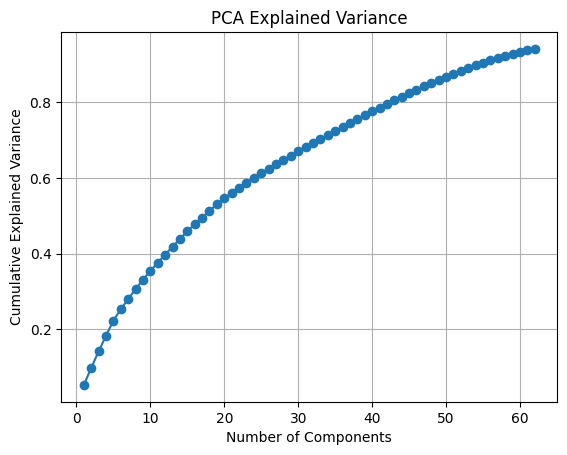

In [246]:
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()


In [249]:
# dump pca info to file for use in another notebook

import joblib

joblib.dump((X_pca, y), '../data/pca_pipeline.joblib')


['../data/pca_pipeline.joblib']